In [20]:
# imports

# external modules
import sys
import os
import numpy as np
import pandas as pd
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
# framework modules
sys.path.append('../')
import plotting.plottools
importlib.reload(plotting.plottools)
from plotting.plottools import plot_histogram
import training.prepare_training_set
importlib.reload(training.prepare_training_set)
from training.prepare_training_set import prepare_training_data_from_files
import training.patternfiltering
importlib.reload(training.patternfiltering)
from training.patternfiltering import contains_any_pattern
import datagen.fake_anomaly
importlib.reload(datagen.fake_anomaly)

<module 'datagen.fake_anomaly' from '/eos/home-i00/l/llambrec/pixelae/evaluation/../datagen/fake_anomaly.py'>

In [21]:
# load the evaluation sets

mes = ([
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1',
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+2',
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+3',
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_-1',
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_-2',
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_-3',
])

eras = ([
    'Run2023C-PromptReco-v1'
])

kwargs = ({
    'verbose': True,
    'entries_threshold': 10000,
    'skip_first_lumisections': 5,
    'veto_patterns': [np.zeros((2,2)), np.zeros((2,1)), np.zeros((1,2))]
})

eval_data = {}
for me in mes:
    files = ['../data/data/ZeroBias-{}-DQMIO-{}_preprocessed.parquet'.format(era, me) for era in eras]
    (data, runs, lumis) = prepare_training_data_from_files(files, **kwargs)
    eval_data[me] = {'data': data, 'runs': runs, 'lumis': lumis}

Loading file ../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1_preprocessed.parquet
  Shape of hists array: (18065, 32, 32)
  Runs: [367094 367094 367094 ... 367515 367515 367515]
  Lumis: [  1   2   3 ... 666 667 668]
  Entries: [    0     0     0 ... 69383 67139 23294]
  Passing number of entries: 16503 (91.35 %)
  Passing lumisection skip: 17794 (98.50 %)
  Passing veto patterns: 6417 (35.52 %)
  Training lumisections: 6303 (34.89 %)
Shape of training data: (6303, 32, 32, 1)
Shape of training runs: (6303,)
Shape of training lumis: (6303,)
Loading file ../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+2_preprocessed.parquet
  Shape of hists array: (18065, 32, 32)
  Runs: [367094 367094 367094 ... 367515 367515 367515]
  Lumis: [  1   2   3 ... 666 667 668]
  Entries: [    0     0     0 ... 63615 61660 21400]
  Passing number of entries: 16498 (91.33 %)
 

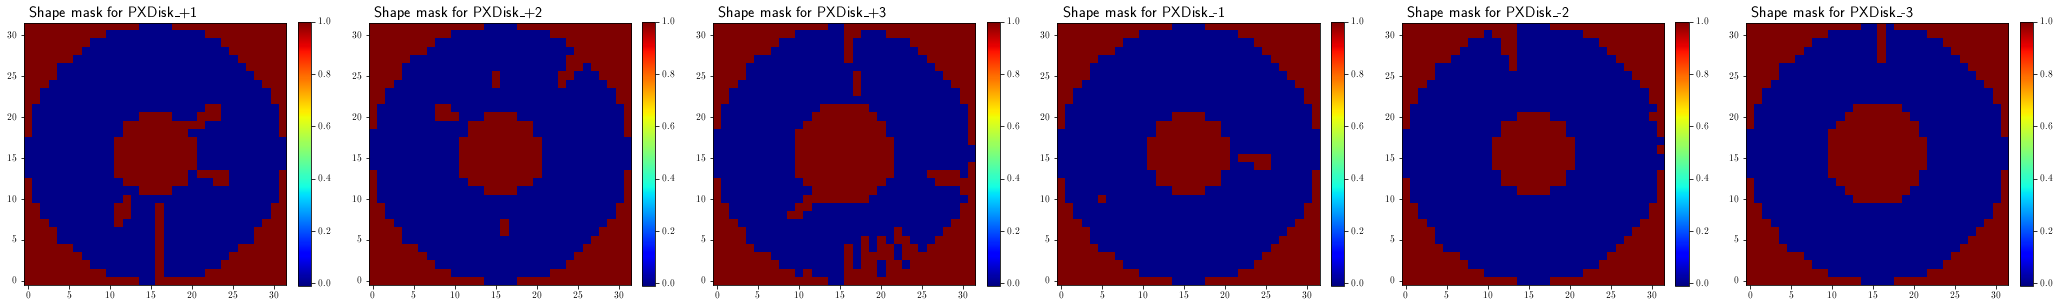

In [22]:
# make masks where values are often zero

for me in mes:
    this_eval_data = eval_data[me]['data']
    shape_mask = (np.sum(this_eval_data[:,:,:,0]==0, axis=0)>len(this_eval_data)*0.5)
    
    # temp: also set edges to zero
    #shape_mask[0,:] = 1
    #shape_mask[-1,:] = 1
    #shape_mask[:,0] = 1
    #shape_mask[:,-1] = 1
    
    eval_data[me]['shape_mask'] = shape_mask

fig,axs = plt.subplots(figsize=(len(mes*6),6), ncols=len(mes))
for i, me in enumerate(mes):
    plot_histogram(eval_data[me]['shape_mask'], fig=fig, ax=axs[i], caxrange=(-0.01,1))
    axs[i].text(0.02, 1.02, 'Shape mask for {}'.format(me.split('_ontrack_')[1]), transform=axs[i].transAxes, fontsize=15)

In [23]:
# load keras models

modelbase = '../models/output_20231115/model_20231115_Run2023C-v1'

for me in mes:
    modelname = '{}_{}.keras'.format(modelbase, me)
    model = keras.models.load_model(modelname)
    eval_data[me]['model'] = model

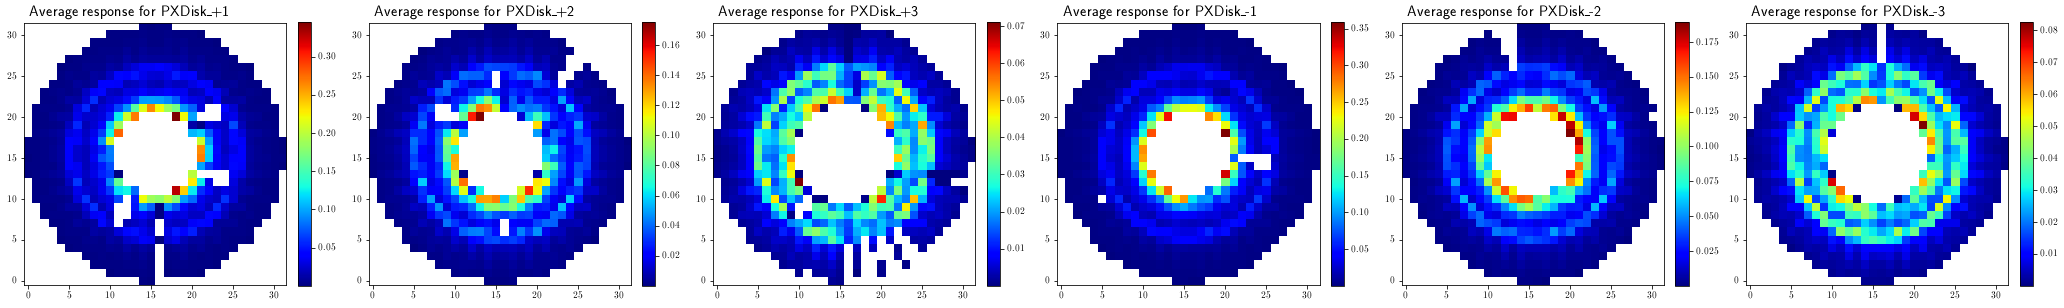

In [25]:
# load average occupancy or error of training sets

for me in mes:
    avgresponsename = '{}_{}_avgoccupancy.npy'.format(modelbase, me)
    avgresponse = np.load(avgresponsename)
    avgresponse = np.square(avgresponse)
    eval_data[me]['avgresponse'] = avgresponse

fig,axs = plt.subplots(figsize=(len(mes*6),6), ncols=len(mes))
for i, me in enumerate(mes):
    plot_histogram(eval_data[me]['avgresponse'], fig=fig, ax=axs[i])
    axs[i].text(0.02, 1.02, 'Average response for {}'.format(me.split('_ontrack_')[1]), transform=axs[i].transAxes, fontsize=15)
    
for me in mes:
    avgresponse = eval_data[me]['avgresponse']
    avgresponse[avgresponse==0] = 1
    avgresponse = np.expand_dims(avgresponse, axis=2)
    eval_data[me]['avgresponse'] = avgresponse

In [26]:
# make collections of fake anomalies

nanomalies = 6000

for me in mes:
    this_eval_data = eval_data[me]['data']
    this_shape_mask = eval_data[me]['shape_mask']
    random_indices = np.random.choice(len(this_eval_data), size=nanomalies, replace=True)
    anomalies = np.zeros((nanomalies, this_eval_data.shape[1], this_eval_data.shape[2], 1))
    for newidx,origidx in enumerate(random_indices):
        hist = this_eval_data[origidx,:,:,0]
        (anomalous_hist, paramdict) = datagen.fake_anomaly.dead_rectangle(hist, rectangle_min_pixels=2, shape_mask=~this_shape_mask)
        anomalies[newidx,:,:,0] = anomalous_hist
    eval_data[me]['anomalies'] = anomalies

In [27]:
# evaluate the models

for me in mes:
    this_eval_data = eval_data[me]['data']
    this_anomalies = eval_data[me]['anomalies']
    this_model = eval_data[me]['model']
    this_shape_mask = eval_data[me]['shape_mask']
    this_avgresponse = eval_data[me]['avgresponse']
    
    predictions = this_model.predict(this_eval_data)
    predictions[predictions<0] = 0.
    predictions[:,this_shape_mask] = 0.

    predictions_anomalies = this_model.predict(this_anomalies)
    predictions_anomalies[predictions_anomalies<0] = 0.
    predictions_anomalies[:,this_shape_mask] = 0.
    
    errors = np.square(this_eval_data - predictions)
    errors[:,this_shape_mask] = 0.
    errors_anomalies = np.square(this_anomalies - predictions_anomalies)
    errors_anomalies[:,this_shape_mask] = 0.

    errors_corrected = errors/this_avgresponse
    errors_anomalies_corrected = errors_anomalies/this_avgresponse
    
    eval_data[me]['errors_corrected'] = errors_corrected
    eval_data[me]['errors_anomalies_corrected'] = errors_anomalies_corrected
    # maybe later add predictions and uncorrected errors as well

188/188 [==============================] - 2s 12ms/step


In [28]:
# scan thresholds to make ROC curves

thresholds = [0.25, 0.4, 0.5, 0.6, 0.75, 1]
patterns = [-np.ones((2,2)), -np.ones((2,1)), -np.ones((1,2))]

for me in mes:
    print('Running on ME {}'.format(me))
    errors_corrected = eval_data[me]['errors_corrected']
    errors_anomalies_corrected = eval_data[me]['errors_anomalies_corrected']
    s_eff = []
    b_eff = []
    for i, threshold in enumerate(thresholds):
        print('  Threshold {} of {}'.format(i+1, len(thresholds)))
        errors_scaled = np.where(errors_corrected>threshold, -1, errors_corrected)
        errors_anomalies_scaled = np.where(errors_anomalies_corrected>threshold, -1, errors_anomalies_corrected)
        flags = contains_any_pattern(errors_scaled[:,:,:,0], patterns)
        flags_anomalies = contains_any_pattern(errors_anomalies_scaled[:,:,:,0], patterns)
        #print('Threshold: {}'.format(threshold))
        #print('{} out of {} non-anomalous histograms were tagged'.format(sum(flags), len(flags)))
        #print('{} out of {} anomalous histograms were tagged'.format(sum(flags_anomalies), len(flags_anomalies)))
        s_eff.append( sum(flags_anomalies)/len(flags_anomalies) )
        b_eff.append( sum(flags)/len(flags) )
    eval_data[me]['roc'] = (s_eff, b_eff)

Running on ME PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1
  Threshold 1 of 6
  Threshold 2 of 6
  Threshold 3 of 6
  Threshold 4 of 6
  Threshold 5 of 6
  Threshold 6 of 6
Running on ME PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+2
  Threshold 1 of 6
  Threshold 2 of 6
  Threshold 3 of 6
  Threshold 4 of 6
  Threshold 5 of 6
  Threshold 6 of 6
Running on ME PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+3
  Threshold 1 of 6
  Threshold 2 of 6
  Threshold 3 of 6
  Threshold 4 of 6
  Threshold 5 of 6
  Threshold 6 of 6
Running on ME PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_-1
  Threshold 1 of 6
  Threshold 2 of 6
  Threshold 3 of 6
  Threshold 4 of 6
  Threshold 5 of 6
  Threshold 6 of 6
Running on ME PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_-2
  Threshold 1 of 6
  Threshold 2 of 6
  Threshold 3 of 6
  Threshold 4 of 6
  Threshold 5 of 6
  Threshold 6 of 6
Running on ME PixelPhase1-Trac

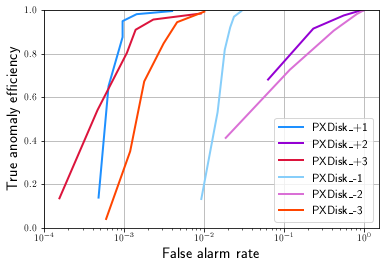

In [29]:
# make a plot

colors = ({
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1': 'dodgerblue',
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+2': 'darkviolet',
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+3': 'crimson',
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_-1': 'lightskyblue',
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_-2': 'orchid',
    'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_-3': 'orangered',
})
fig,ax = plt.subplots()
for me in mes:
    s_eff, b_eff = eval_data[me]['roc']
    ax.plot(b_eff, s_eff, label=me.split('_ontrack_')[1], color=colors[me], linewidth=2)
ax.legend(fontsize=12)
ax.set_xlabel('False alarm rate', fontsize=15)
ax.set_ylabel('True anomaly efficiency', fontsize=15)
ax.grid()
ax.set_ylim((0,1))
ax.set_xscale('log')
plt.show()